In [1]:
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

from power_prediction.baseline_model import plot_residuals
from power_prediction.util import split_data_train_test, make_column_names_model_safe, plot_target_and_predictions
from power_prediction.load_dataset import load_data_residuals_remove_nan, load_data_default_remove_nan, resample_hourly_to_daily

# Random Forest with default Dataset

In [2]:
df = load_data_default_remove_nan()

Make the column names safe for the model and split the test and training data with the custom split function, leaving the last year of data in the test set

In [3]:
df_original = make_column_names_model_safe(df)

In [4]:
train, test = split_data_train_test(df_original)
train = train.drop("Date", axis=1)
test_dates = test["Date"].copy()
test = test.drop("Date", axis=1)

Since the custom test/train split does not shuffle the data, this is now done for the test data with a reproducible random state

In [5]:
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

Both training and test data are now split into X = predictors and Y = target

In [6]:
target_column = 'NE_tot'  # One of 'Value_NE5', 'Value_NE7', 'NE_tot'
predictor_columns = ['Hr', 'RainDur', 'StrGlo', 'T', 'WD', 'WVs', 'WVv', 'p', 'Vacation', 'Holiday', 'Year', 'Month', 'Day', 'Hour', 'Weekday', 'Corona']

In [7]:
X_train = train[predictor_columns]
y_train = train[target_column]
X_test = test[predictor_columns]
y_test = test[target_column]

### Model setup

For random forest regression, `XGBRFRegressor` from the `xgboost` python library is used.
The following parameters are available for hyperparemeter tuning.

- `n_estimators`: The number of decision trees the ensemble model includes
- `max_depth`: The maximum depth the tree is allowed to reach
- `learning_rate`: The strength of each tree's predictions in the ensemble
- `subsample`: The fraction of samples used for training each tree
- `colsample_bynode`: The fraction of features used for training each tree
- `reg_lambda`: L2 regularization term. Higher value makes model less likely to overfit
- `reg_alpha`: L1 regularization term. Higher value makes trees more sparse and more interpretable

In [8]:
hyperparameters = {
    "random_state": 42,
    "n_estimators": 100,
    "max_depth": 6,
    "learning_rate": 1.0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "reg_alpha": 0.0,
    "enable_categorical": True
}

In [9]:
model = XGBRFRegressor(**hyperparameters)

In [10]:
model.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=0.8, device=None,
               early_stopping_rounds=None, enable_categorical=True,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, reg_alpha=0.0, ...)

In [11]:
y_pred = model.predict(X_test)

#### Model error evaluation

In [12]:
print(
    f"MSE:  {mean_squared_error(y_test, y_pred):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test, y_pred):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}\n"
    f"R2:   {r2_score(y_test, y_pred):.3f}\n"
)

MSE:  655682117.979
MAE:  21886.759
MAPE: 0.079
R2:   0.828



### Residuals Plot

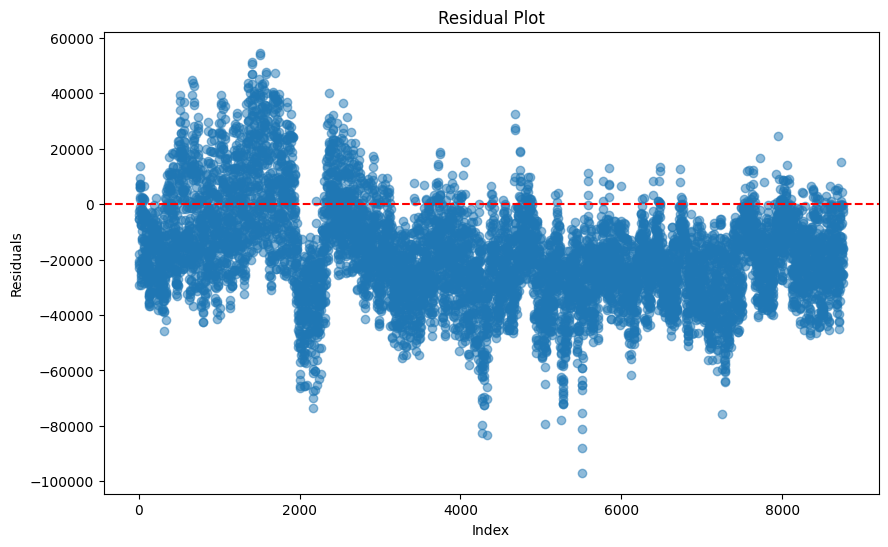

In [13]:
plot_residuals(y_test, y_pred)

### Target vs. Prediction plot

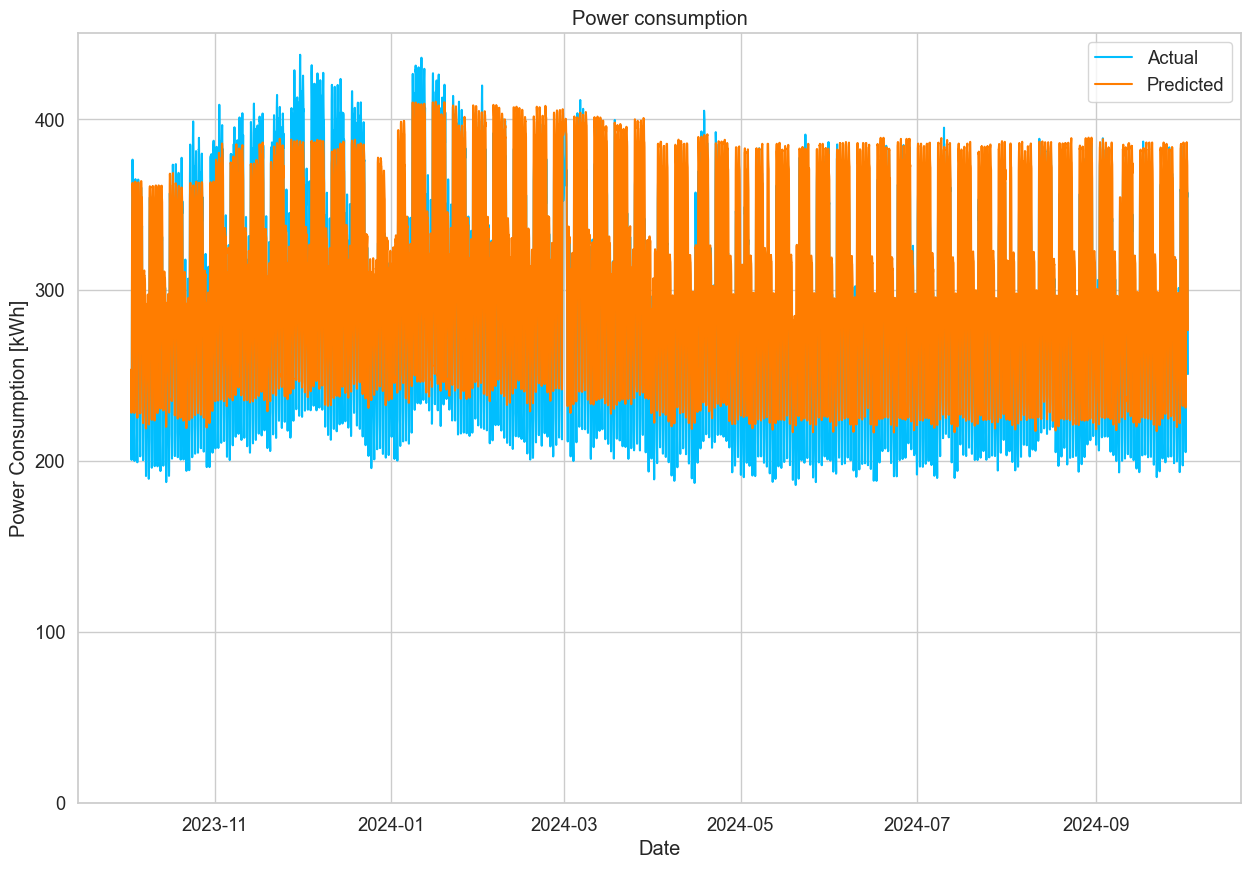

In [14]:
plot_target_and_predictions(test_dates, y_test / 1e3, y_pred / 1e3, "Power consumption", "Date", "Power Consumption [MWh]")

# Hyperparameter tuning on default dataset

In [15]:
model = XGBRFRegressor()

In [16]:
parameter_grid = {
    'random_state': [42],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [7, 8, 9, 10, 11],
    'learning_rate': [0.1, 0.5, 1.0, 1.5, 2.0, 2.5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'enable_categorical': [True],
}

Create a grid search instance

In [17]:
grid_search = RandomizedSearchCV(
    model, 
    parameter_grid,
    random_state=42,
    n_iter=200,
    cv=5,                    
    scoring='r2',
    n_jobs=-1
)

In [18]:
grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRFRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            max_bin=None,
                                            max_cat_threshold=Non...
                                            num_parallel_tree=None,
                                            objective='reg:squarederror',
                                            random_state=None, reg_alpha=None, ...),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'enable_categorical': [True],
                                        'learning_rate': [0.1, 0.5, 1.0, 1.5,
                                                          2.0, 2.5],
                                        'max_depth': [7, 8, 9, 10, 11],
                                        'n_estimators': [50, 100, 200, 300],
                                        'random_state': [42],
                                        'subsample': [0.7, 0.8, 1.0]},
                   random_state=42, scoring='r2')

In [19]:
params = grid_search.best_params_
model = grid_search.best_estimator_
print("Best parameters found:", params)
print("Best model:", model)

Best parameters found: {'subsample': 1.0, 'random_state': 42, 'n_estimators': 100, 'max_depth': 11, 'learning_rate': 1.0, 'enable_categorical': True, 'colsample_bytree': 1.0}
Best model: XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=1.0, device=None,
               early_stopping_rounds=None, enable_categorical=True,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=11, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, reg_alpha=None, ...)


Predict with best found model

In [20]:
y_pred = model.predict(X_test)

#### Model error evaluation

In [21]:
print(
    f"MSE:  {mean_squared_error(y_test, y_pred):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test, y_pred):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}\n"
    f"R2:   {r2_score(y_test, y_pred):.3f}\n"
)

MSE:  737631438.976
MAE:  21645.994
MAPE: 0.071
R2:   0.807



#### Model residuals plot

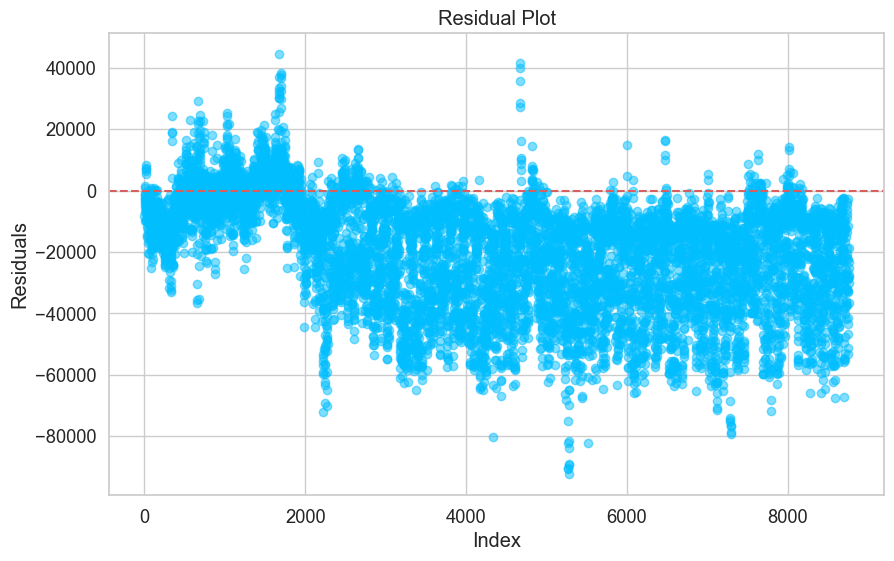

In [22]:
plot_residuals(y_test, y_pred)

### Target vs. Prediction plot

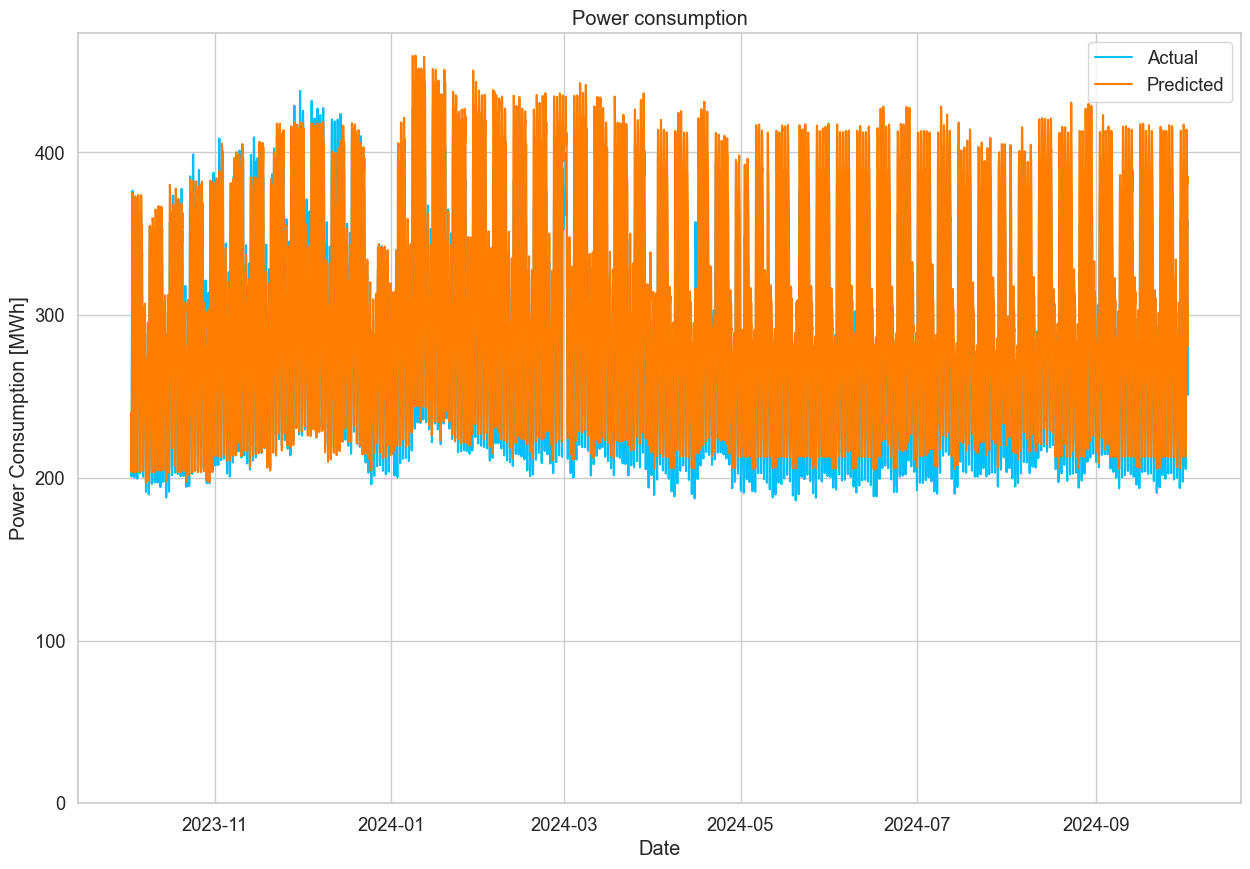

In [23]:
plot_target_and_predictions(test_dates, y_test / 1e3, y_pred / 1e3, "Power consumption", "Date", "Power Consumption [MWh]")

# Hyperparameter Tuning on default daily aggregated data

Aggregate data from hourly to daily

In [24]:
df_aggregated = df_original.set_index('Date')
sum_cols = ["Value_NE5", "Value_NE7", "NE_tot", "RainDur", "StrGlo"]
avg_cols = ["Hr", "T", "WD", "WVs", "WVv", "p"]
first_cols = ["Year", "Month", "Day", "Hour", "Weekday", "Vacation", "Holiday", "Corona"]
df_aggregated = resample_hourly_to_daily(df_aggregated, sum_cols, avg_cols, first_cols)
df_aggregated.reset_index(inplace=True)

Make test/train split with one year of data as test data

In [25]:
train, test = split_data_train_test(df_aggregated)
train = train.drop("Date", axis=1)
test_dates = test["Date"].copy()
test = test.drop("Date", axis=1)

Since the custom test / train split does not shuffle the data, this is now done for the test data with a reproducible random state

In [26]:
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

Both training and test data are now split into X = predictors and Y = target 

In [27]:
target_column = 'NE_tot'  # One of 'Value_NE5', 'Value_NE7', 'NE_tot'
predictor_columns = ['Hr', 'RainDur', 'StrGlo', 'T', 'WD', 'WVs', 'WVv', 'p', 'Vacation', 'Holiday', 'Year', 'Month', 'Day', 'Weekday', 'Corona']

In [28]:
X_train = train[predictor_columns]
y_train = train[target_column]
X_test = test[predictor_columns]
y_test = test[target_column]

Create model and parameter grid

In [29]:
model = XGBRFRegressor()

In [30]:
parameter_grid = {
    'random_state': [42],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 6, 7, 8, 9],
    'learning_rate': [0.1, 0.5, 1.0, 1.5, 2.0, 2.5],
    'subsample': [0.5, 0.6, 0.7, 0.8],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'enable_categorical': [True],
}

Create grid search instance

In [31]:
grid_search = RandomizedSearchCV(
    model,
    parameter_grid,
    random_state=42,
    n_iter=200,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

In [32]:
grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRFRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            max_bin=None,
                                            max_cat_threshold=Non...
                                            num_parallel_tree=None,
                                            objective='reg:squarederror',
                                            random_state=None, reg_alpha=None, ...),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'enable_categorical': [True],
                                        'learning_rate': [0.1, 0.5, 1.0, 1.5,
                                                          2.0, 2.5],
                                        'max_depth': [5, 6, 7, 8, 9],
                                        'n_estimators': [50, 100, 200, 300],
                                        'random_state': [42],
                                        'subsample': [0.5, 0.6, 0.7, 0.8]},
                   random_state=42, scoring='r2')

In [33]:
params = grid_search.best_params_
model = grid_search.best_estimator_
print("Best parameters found:", params)
print("Best model:", model)

Best parameters found: {'subsample': 0.8, 'random_state': 42, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 1.0, 'enable_categorical': True, 'colsample_bytree': 1.0}
Best model: XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=1.0, device=None,
               early_stopping_rounds=None, enable_categorical=True,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=9, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=300, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, reg_alpha=None, ...)


Predict with best found model

In [34]:
y_pred = model.predict(X_test)

### Model error evaluation

In [35]:
print(
    f"MSE:  {mean_squared_error(y_test, y_pred):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test, y_pred):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}\n"
    f"R2:   {r2_score(y_test, y_pred):.3f}\n"
)

MSE:  362077332294.046
MAE:  501333.258
MAPE: 0.073
R2:   0.251



### Model residuals plot

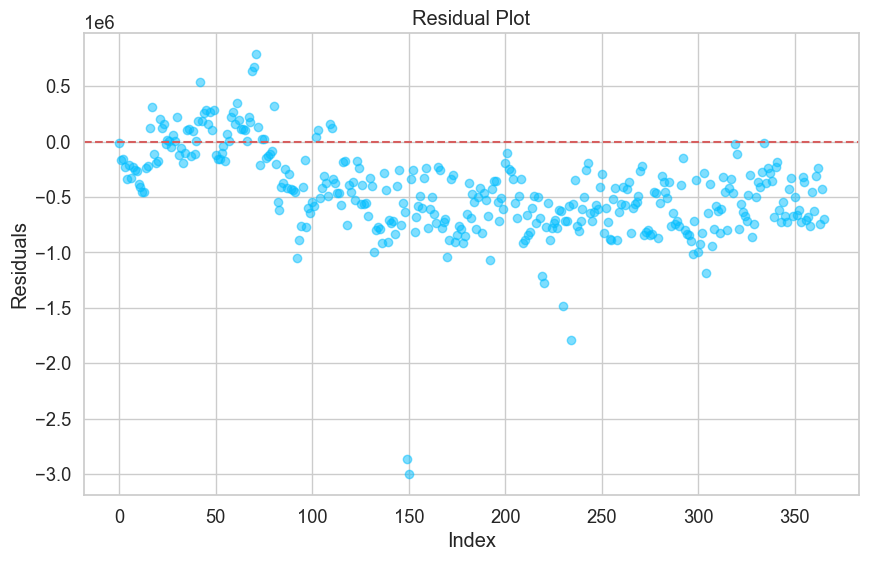

In [36]:
plot_residuals(y_test, y_pred)

### Target vs. Prediction plot

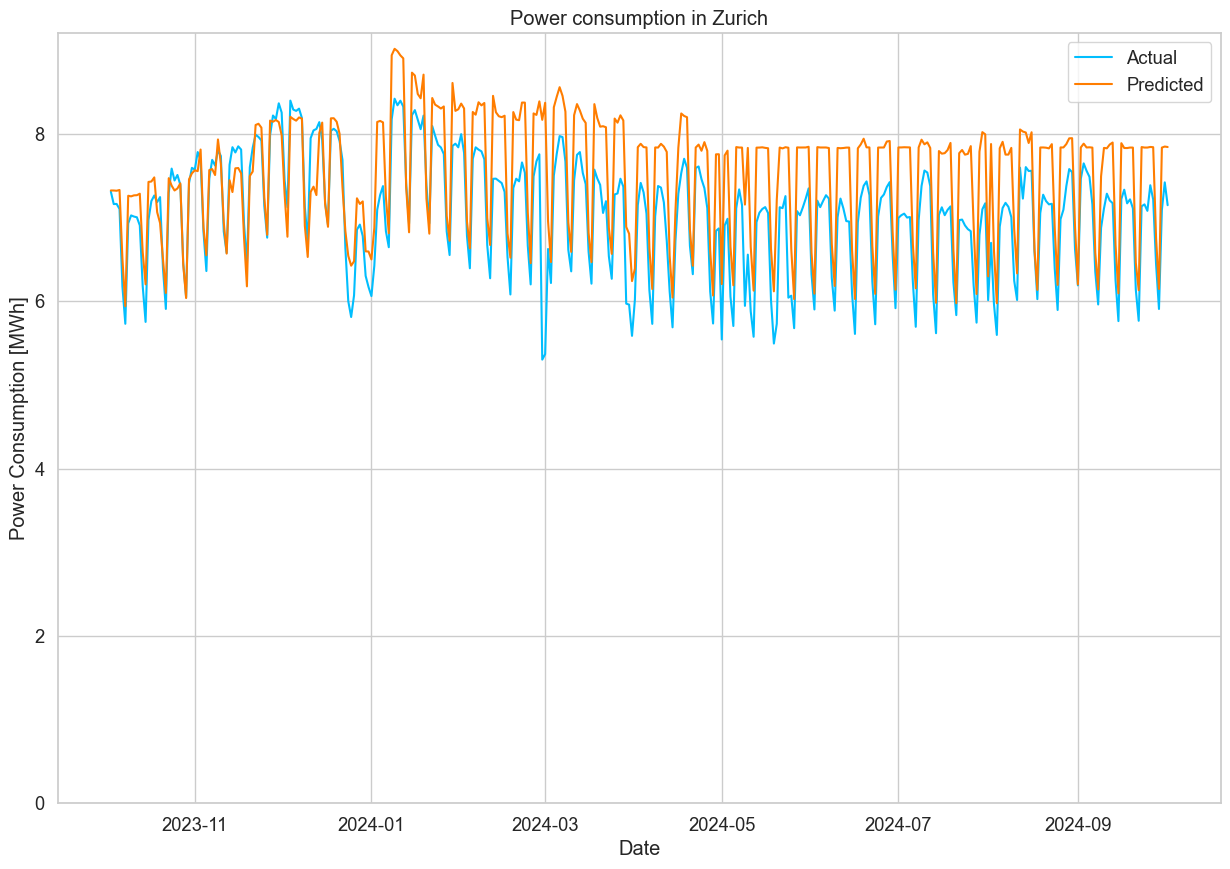

In [37]:
plot_target_and_predictions(test_dates, y_test / 1e6, y_pred / 1e6, "Power consumption in Zurich", "Date", "Power Consumption [MWh]")

# Random Forest with residuals Dataset

In [38]:
df = load_data_residuals_remove_nan()

Drop Date feature, because all time sensitivity has been eliminated with prophet

Remove the units from the column names and split data into training and test set with custom train/test split. test data is the last year of data

In [39]:
df_residuals = make_column_names_model_safe(df)

In [40]:
train, test = split_data_train_test(df_residuals)
train = train.drop("Date", axis=1)
test_dates = test["Date"].copy()
test = test.drop("Date", axis=1)

Since the custom test/train split does not shuffle the data, this is now done for the test data with a reproducible random state

In [41]:
train = train.sample(frac=1, random_state=42).reset_index(drop=True)


Both training and test data are now split into X = predictors and Y = target

In [42]:
target_column = 'NETOT'  # One of 'NE5', 'NE7', 'NETOT'
predictor_columns = ['Hr', 'RainDur', 'StrGlo', 'T', 'WD', 'WVs', 'WVv', 'p']

In [43]:
X_train = train[predictor_columns]
y_train = train[f"{target_column}_remainder"]
X_test = test[predictor_columns]
y_test = test[f"{target_column}_remainder"]
y_test_yhat = test[f"{target_column}_yhat"]

### Model setup

For random forest regression, `XGBRFRegressor` from the `xgboost` python library is used.
The following parameters are available for hyperparemeter tuning.

- `n_estimators`: The number of decision trees the ensemble model includes
- `max_depth`: The maximum depth the tree is allowed to reach
- `learning_rate`: The strength of each tree's predictions in the ensemble
- `subsample`: The fraction of samples used for training each tree
- `colsample_bynode`: The fraction of features used for training each tree
- `reg_lambda`: L2 regularization term. Higher value makes model less likely to overfit
- `reg_alpha`: L1 regularization term. Higher value makes trees more sparse and more interpretable



In [44]:
hyperparameters = {
    "random_state": 42,
    "n_estimators": 100,
    "max_depth": 6,
    "learning_rate": 1.0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "reg_alpha": 0.0,
}

In [45]:
model = XGBRFRegressor(**hyperparameters)

In [46]:
model.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=0.8, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, reg_alpha=0.0, ...)

In [47]:
y_pred = model.predict(X_test)

#### Model error evaluation

On residuals data alone

In [48]:
print(
    f"MSE:  {mean_squared_error(y_test, y_pred):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test, y_pred):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}\n"
    f"R2:   {r2_score(y_test, y_pred):.3f}\n"
)

MSE:  458268328.258
MAE:  16394.566
MAPE: 1.471
R2:   0.053



On residuals data with TSD yhat

In [49]:
print(
    f"MSE:  {mean_squared_error(y_test + y_test_yhat, y_pred + y_test_yhat):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test + y_test_yhat, y_pred + y_test_yhat):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test + y_test_yhat, y_pred + y_test_yhat):.3f}\n"
    f"R2:   {r2_score(y_test + y_test_yhat, y_pred + y_test_yhat):.3f}\n"
)

MSE:  458268328.258
MAE:  16394.566
MAPE: 0.061
R2:   0.880



On tsd yhat data alone

In [50]:
print(
    f"MSE:  {mean_squared_error(y_test_yhat, y_test + y_test_yhat):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test_yhat, y_test + y_test_yhat):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test_yhat, y_test + y_test_yhat):.3f}\n"
    f"R2:   {r2_score(y_test_yhat, y_test + y_test_yhat):.3f}\n"
)

MSE:  483920446.970
MAE:  17121.039
MAPE: 0.066
R2:   0.878



### Model residuals plot (TSD yhat plus residuals)

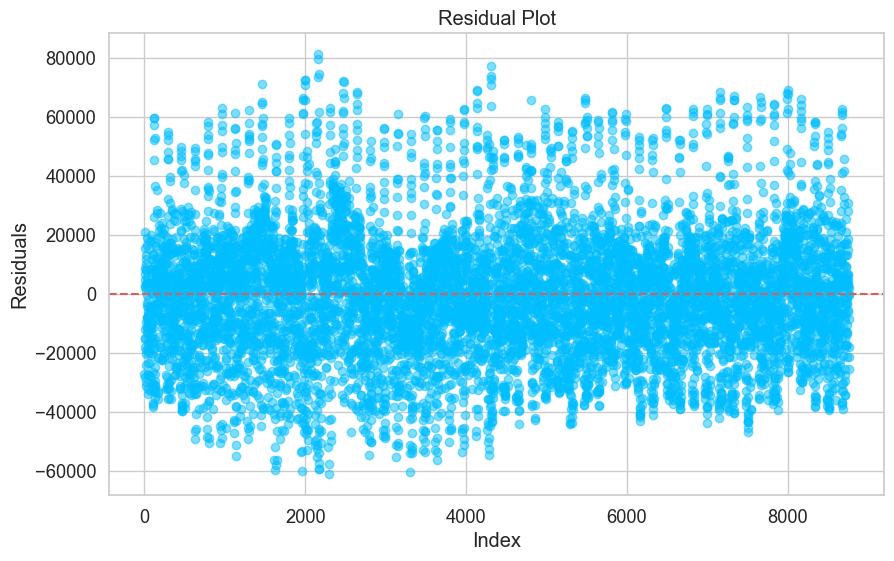

In [51]:
plot_residuals(y_test + y_test_yhat, y_pred + y_test_yhat)

### Target vs. Prediction plot (TSD yhat plus residuals)

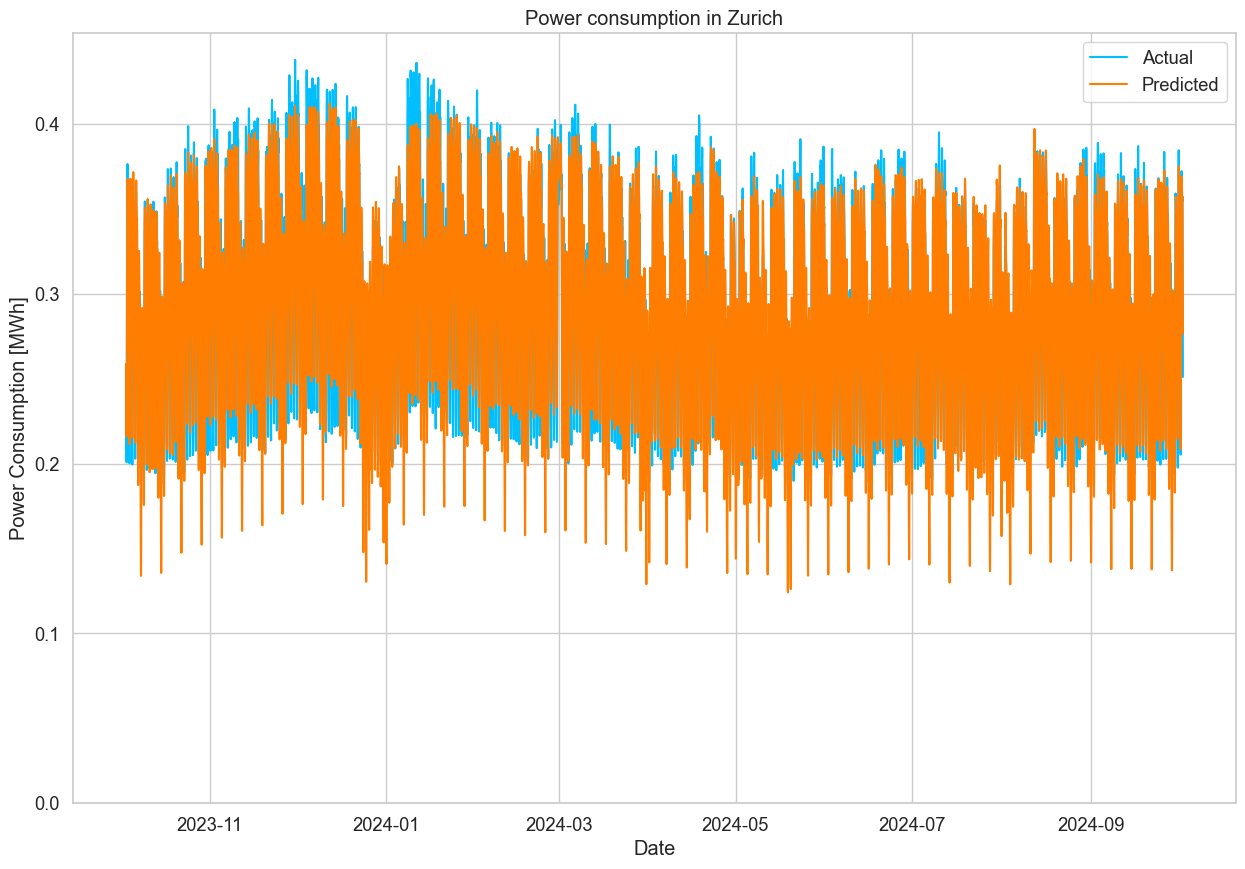

In [52]:
plot_target_and_predictions(test_dates, (y_test + y_test_yhat) / 1e6, (y_pred + y_test_yhat) / 1e6, "Power consumption in Zurich", "Date", "Power Consumption [MWh]")

# Hyperparameter Tuning on residuals Dataset

In [53]:
model = XGBRFRegressor()

In [54]:
parameter_grid = {
    'random_state': [42],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 6, 7, 8, 9],
    'learning_rate': [0.1, 0.5, 1.0, 1.5, 2.0, 2.5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'enable_categorical': [True],
}

Create randomized search instance

In [55]:
grid_search = RandomizedSearchCV(
    model, 
    parameter_grid,
    random_state=42,
    n_iter=200,
    cv=5,                    
    scoring='r2',
    n_jobs=-1
)

In [56]:
grid_search.fit(X_train, y_train)

C:\git\DSPRO1-power-prediction\.env3\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5,
                   estimator=XGBRFRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            max_bin=None,
                                            max_cat_threshold=Non...
                                            num_parallel_tree=None,
                                            objective='reg:squarederror',
                                            random_state=None, reg_alpha=None, ...),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'enable_categorical': [True],
                                        'learning_rate': [0.1, 0.5, 1.0, 1.5,
                                                          2.0, 2.5],
                                        'max_depth': [5, 6, 7, 8, 9],
                                        'n_estimators': [50, 100, 200, 300],
                                        'random_state': [42],
                                        'subsample': [0.7, 0.8, 1.0]},
                   random_state=42, scoring='r2')

In [57]:
params = grid_search.best_params_
model = grid_search.best_estimator_
print("Best parameters found:", params)
print("Best model:", model)

Best parameters found: {'subsample': 0.8, 'random_state': 42, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 2.0, 'enable_categorical': True, 'colsample_bytree': 0.7}
Best model: XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=0.7, device=None,
               early_stopping_rounds=None, enable_categorical=True,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=2.0, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=9, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=300, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, ...)


Predict with best found model

In [58]:
y_pred = model.predict(X_test)

#### Model error evaluation

on residuals data alone

In [59]:
print(
    f"MSE:  {mean_squared_error(y_test, y_pred):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test, y_pred):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}\n"
    f"R2:   {r2_score(y_test, y_pred):.3f}\n"
)

MSE:  448296032.078
MAE:  16096.513
MAPE: 2.009
R2:   0.073



on residuals data plus TSD yhat

In [60]:
print(
    f"MSE:  {mean_squared_error(y_test + y_test_yhat, y_pred + y_test_yhat):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test + y_test_yhat, y_pred + y_test_yhat):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test + y_test_yhat, y_pred + y_test_yhat):.3f}\n"
    f"R2:   {r2_score(y_test + y_test_yhat, y_pred + y_test_yhat):.3f}\n"
)

MSE:  448296032.078
MAE:  16096.513
MAPE: 0.060
R2:   0.883



On TSD yhat alone

In [61]:
print(
    f"MSE:  {mean_squared_error(y_test_yhat, y_test + y_test_yhat):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test_yhat, y_test + y_test_yhat):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test_yhat, y_test + y_test_yhat):.3f}\n"
    f"R2:   {r2_score(y_test_yhat, y_test + y_test_yhat):.3f}\n"
)

MSE:  483920446.970
MAE:  17121.039
MAPE: 0.066
R2:   0.878



### Model residuals plot (TSD yhat plus residuals)

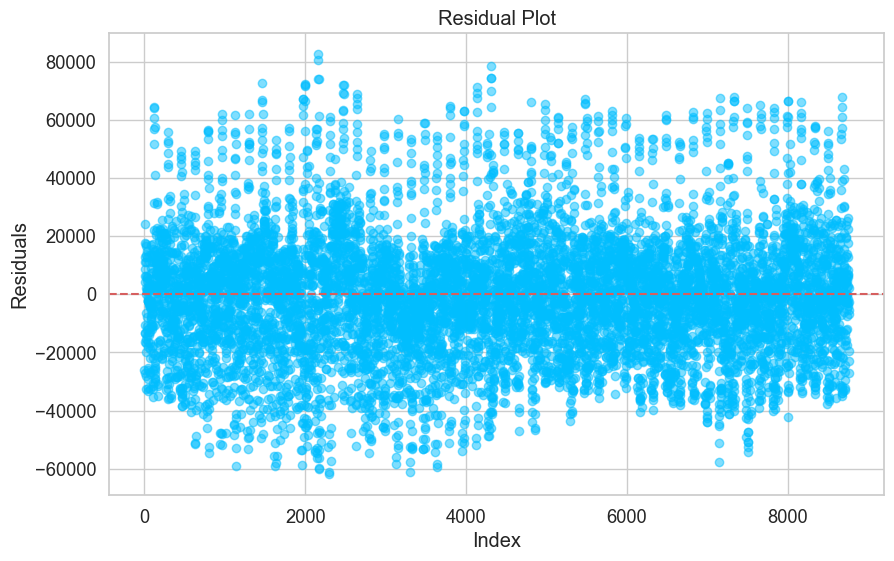

In [62]:
plot_residuals(y_test + y_test_yhat, y_pred + y_test_yhat)

### Target vs. Predicition plot (TSD yhat plus residuals)

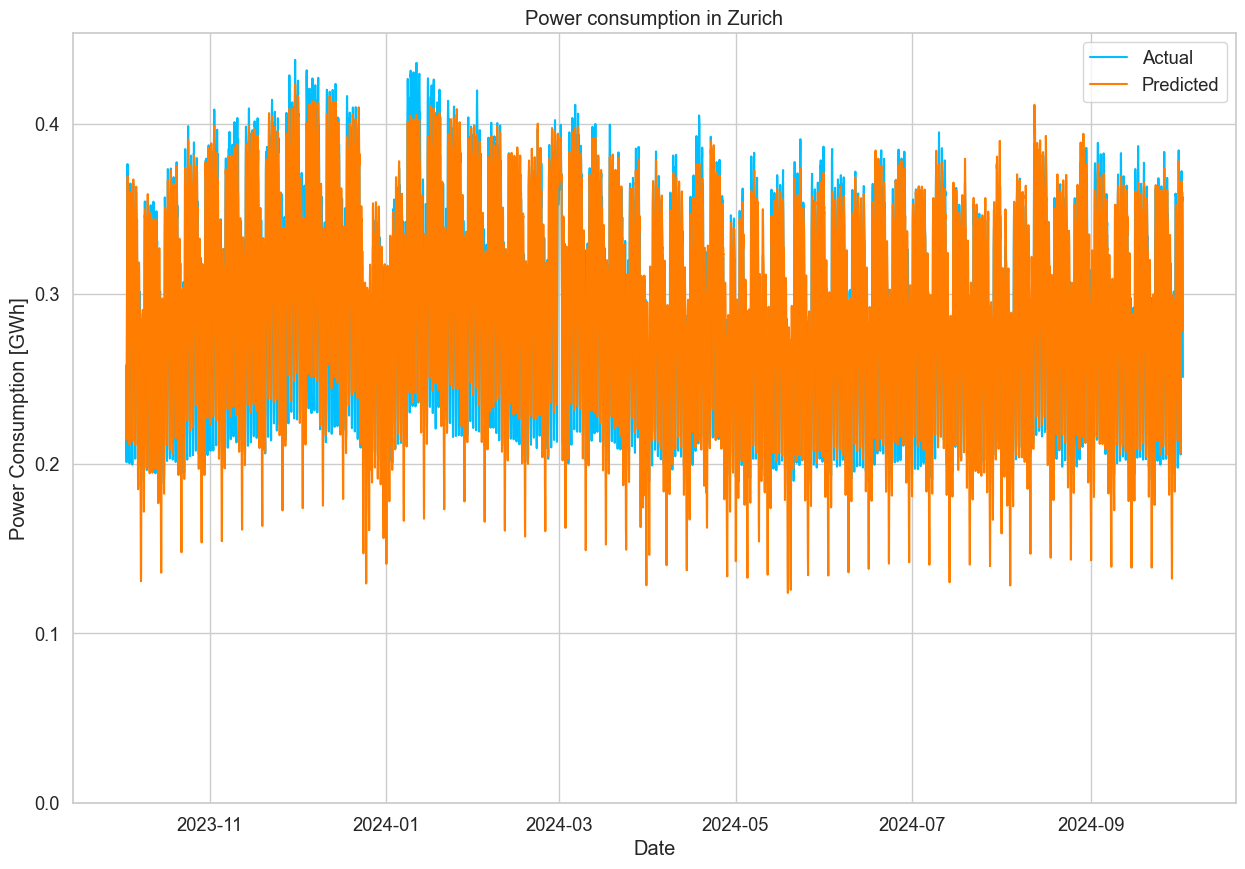

In [63]:
plot_target_and_predictions(test_dates, (y_test + y_test_yhat) / 1e6, (y_pred + y_test_yhat) / 1e6, "Power consumption in Zurich", "Date", "Power Consumption [GWh]")

# Hyperparameter tuning on daily aggregated residual data

aggregate residual data from hourly to daily

In [64]:
df_aggregated = df_residuals.set_index('Date')
sum_cols = ["NE5_remainder", "NE5_yhat", "NE7_remainder", "NE7_yhat", "NETOT_remainder", "NETOT_yhat", "RainDur", "StrGlo"]
avg_cols = ["Hr", "T", "WD", "WVs", "WVv", "p"]
df_aggregated = resample_hourly_to_daily(df_aggregated, sum_cols, avg_cols, [])
df_aggregated.reset_index(inplace=True)

Split data into training and test set

In [65]:
train, test = split_data_train_test(df_aggregated)
train = train.drop("Date", axis=1)
test_dates = test["Date"].copy()
test = test.drop("Date", axis=1)

shuffle training data

In [66]:
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

Split target and prediction features

In [67]:
target_column = 'NETOT_remainder'  # One of 'NE5_remainder', 'NE7_remainder', 'NETOT_remainder'
predictor_columns = ['Hr', 'RainDur', 'StrGlo', 'T', 'WD', 'WVs', 'WVv', 'p']

In [68]:
X_train = train[predictor_columns]
y_train = train[target_column]
X_test = test[predictor_columns]
y_test = test[target_column]
y_test_yhat = test["NETOT_yhat"]

Setup model and hyperparemeter grid

In [69]:
model = XGBRFRegressor()

In [70]:
parameter_grid = {
    'random_state': [42],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 6, 7, 8, 9],
    'learning_rate': [0.1, 0.5, 1.0, 1.5, 2.0, 2.5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'enable_categorical': [True],
}

setup grid search instance

In [71]:
grid_search = RandomizedSearchCV(
    model,
    parameter_grid,
    random_state=42,
    n_iter=200,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

In [72]:
grid_search.fit(X_train, y_train)

C:\git\DSPRO1-power-prediction\.env3\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5,
                   estimator=XGBRFRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            max_bin=None,
                                            max_cat_threshold=Non...
                                            num_parallel_tree=None,
                                            objective='reg:squarederror',
                                            random_state=None, reg_alpha=None, ...),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'enable_categorical': [True],
                                        'learning_rate': [0.1, 0.5, 1.0, 1.5,
                                                          2.0, 2.5],
                                        'max_depth': [5, 6, 7, 8, 9],
                                        'n_estimators': [50, 100, 200, 300],
                                        'random_state': [42],
                                        'subsample': [0.7, 0.8, 1.0]},
                   random_state=42, scoring='r2')

In [73]:
params = grid_search.best_params_
model = grid_search.best_estimator_
print("Best parameters found:", params)
print("Best model:", model)

Best parameters found: {'subsample': 0.7, 'random_state': 42, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 1.0, 'enable_categorical': True, 'colsample_bytree': 0.8}
Best model: XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=0.8, device=None,
               early_stopping_rounds=None, enable_categorical=True,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=8, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, reg_alpha=None, ...)


Make prediction with best found model

In [74]:
y_pred = model.predict(X_test)

### Model error evaluation

On raw time series decomposited data

In [75]:
print(
    f"MSE:  {mean_squared_error(y_test, y_pred):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test, y_pred):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}\n"
    f"R2:   {r2_score(y_test, y_pred):.3f}\n"
)

MSE:  18013285594.570
MAE:  101444.762
MAPE: 125.176
R2:   0.319



On time series prediction and residuals data

In [76]:
print(
    f"MSE:  {mean_squared_error(y_test + y_test_yhat, y_pred + y_test_yhat):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test + y_test_yhat, y_pred + y_test_yhat):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test + y_test_yhat, y_pred + y_test_yhat):.3f}\n"
    f"R2:   {r2_score(y_test + y_test_yhat, y_pred + y_test_yhat):.3f}\n"
)

MSE:  18013285594.570
MAE:  101444.762
MAPE: 0.014
R2:   0.963



On tsd yhat alone

In [77]:
print(
    f"MSE:  {mean_squared_error(y_test_yhat, y_test + y_test_yhat):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test_yhat, y_test + y_test_yhat):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test_yhat, y_test + y_test_yhat):.3f}\n"
    f"R2:   {r2_score(y_test_yhat, y_test + y_test_yhat):.3f}\n"
)

MSE:  26516478412.041
MAE:  112196.947
MAPE: 0.016
R2:   0.944



### Residuals plot (TSD yhat plus residuals)

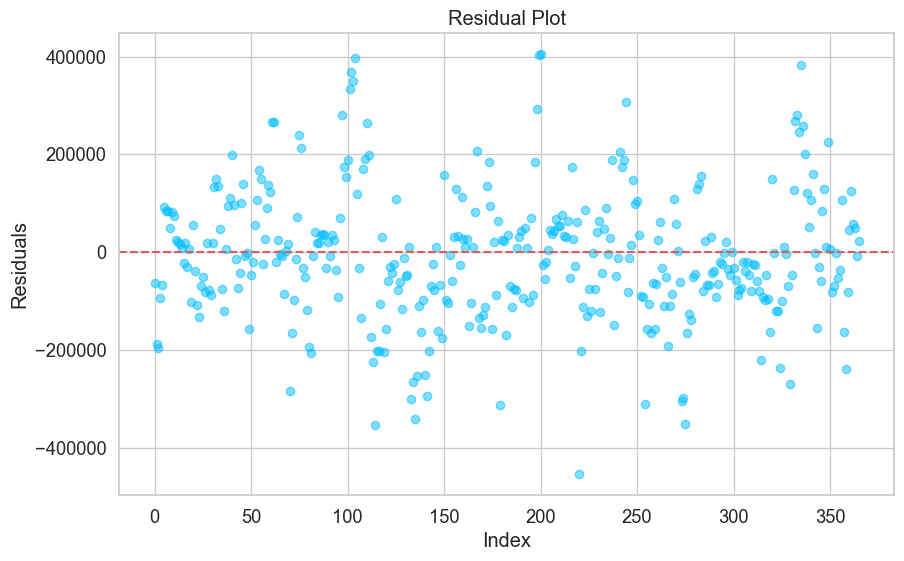

In [78]:
plot_residuals(y_test + y_test_yhat, y_pred + y_test_yhat)

### Target vs. Prediction Plot (TSD yhat + residuals)

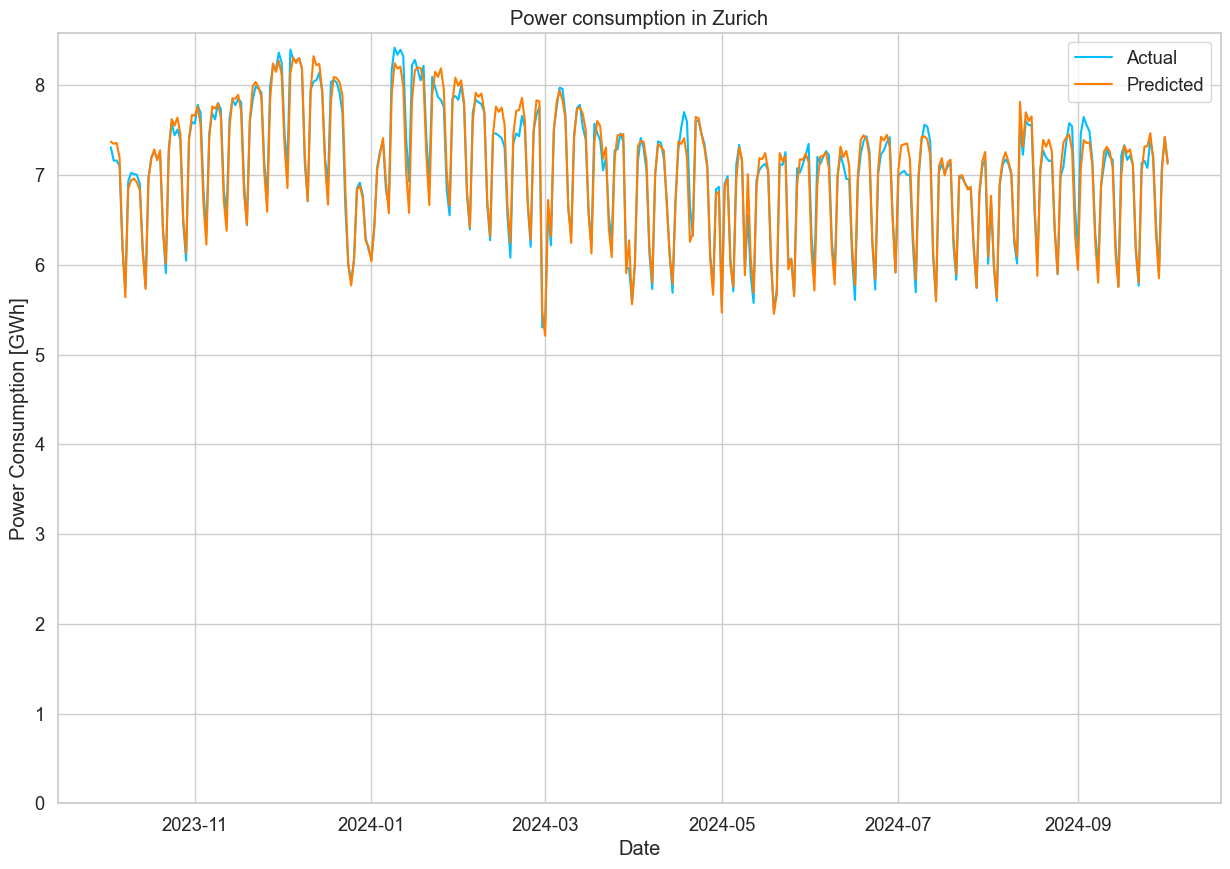

In [79]:
plot_target_and_predictions(test_dates, (y_test + y_test_yhat) / 1e6, (y_pred + y_test_yhat) / 1e6, "Power consumption in Zurich", "Date", "Power Consumption [GWh]")